In [1]:
import sys
print(sys.executable)
print(sys.version)

/Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/.venv/bin/python
3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]


In [2]:
import pandas as pd
pd.__version__

import os 
os.getcwd()

'/Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/notebooks'

In [4]:
import sqlite3, os, pandas as pd

print("CWD:", os.getcwd())

REPO_ROOT = os.path.dirname(os.getcwd()) # assuming the notebook is in the root of the repo # goes up from notebooks/ to the repo root
DB_PATH = os.path.join(REPO_ROOT, "data", "training.sqlite")

print("DB_PATH:", DB_PATH)
print("DB exists?", os.path.exists(DB_PATH))

conn = sqlite3.connect(DB_PATH)
weekly = pd.read_sql_query("SELECT * FROM weekly_e1rm ORDER BY week_start, exercise", conn)
conn.close()

weekly


CWD: /Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/notebooks
DB_PATH: /Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/data/training.sqlite
DB exists? True


,week_start,exercise,e1rm
0,2026-02-02,Bench Press,116.666667
1,2026-02-02,Deadlift,204.166667
2,2026-02-02,Squat,160.416667
3,2026-02-09,Bench Press,115.500000
4,2026-02-09,Deadlift,203.500000
5,2026-02-09,Squat,159.500000


In [6]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 7.7 MB/s  0:00:01 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 13.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt

# Make a tidy datetime column for plotting
weekly_plot = weekly.copy()
weekly_plot["week_start"] = pd.to_datetime(weekly_plot["week_start"])

# Pivot so each lift becomes a column
wide = weekly_plot.pivot(index="week_start", columns="exercise", values="e1rm").sort_index()
wide


exercise,Bench Press,Deadlift,Squat
week_start,,,
2026-02-02,116.666667,204.166667,160.416667
2026-02-09,115.500000,203.500000,159.500000


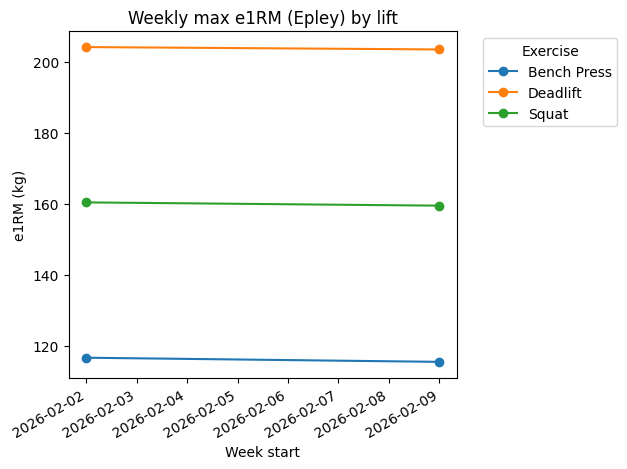

In [9]:
ax = wide.plot(marker="o")
ax.set_title("Weekly max e1RM (Epley) by lift")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")

# Position the legend outside the plot area
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

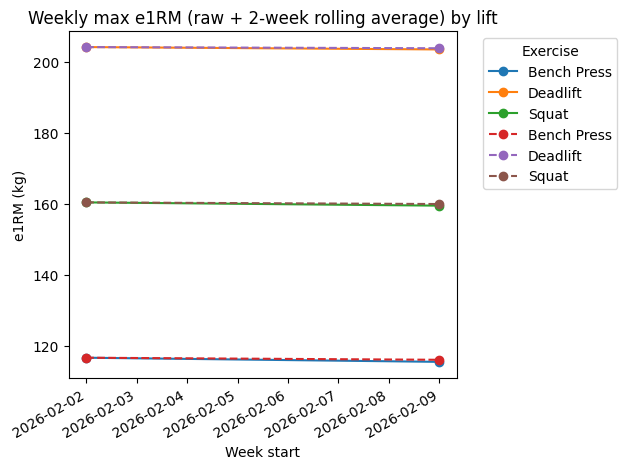

In [10]:
# Add a 2-week rolling average to smooth out the lines
wide_roll2 = wide.rolling(window=2, min_periods=1).mean()

ax = wide.plot(marker="o")
wide_roll2.plot(ax=ax, marker="o", linestyle="--")
ax.set_title("Weekly max e1RM (raw + 2-week rolling average) by lift")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
%pip install numpy
import numpy as np



Note: you may need to restart the kernel to use updated packages.


In [15]:
# Make a copy so we do not mutate the plotting table
trend_df = weekly_plot.copy()

# Convert week_start to a numeric index (weeks since first observation)
trend_df["week_index"] = (trend_df["week_start"] - trend_df["week_start"].min()).dt.days / 7

trend_df

,week_start,exercise,e1rm,week_index
0,2026-02-02,Bench Press,116.666667,0.0
1,2026-02-02,Deadlift,204.166667,0.0
2,2026-02-02,Squat,160.416667,0.0
3,2026-02-09,Bench Press,115.500000,1.0
4,2026-02-09,Deadlift,203.500000,1.0
5,2026-02-09,Squat,159.500000,1.0


In [19]:
# Fit a simple linear trend per lift

from numpy.polynomial.polynomial import polyfit

trend_results = {}

for exercise in trend_df["exercise"].unique():
    sub = trend_df[trend_df["exercise"] == exercise]
    
    x = sub["week_index"].values
    y = sub["e1rm"].values
    
    # Linear fit: y = a + b*x
    a, b = polyfit(x, y, deg=1)
    
    trend_results[exercise] = {"intercept": a, "slope_per_week": b}

trend_results

{'Bench Press': {'intercept': np.float64(116.66666666666663),
  'slope_per_week': np.float64(-1.166666666666643)},
 'Deadlift': {'intercept': np.float64(204.16666666666657),
  'slope_per_week': np.float64(-0.6666666666666572)},
 'Squat': {'intercept': np.float64(160.41666666666666),
  'slope_per_week': np.float64(-0.9166666666666856)}}

/var/folders/1n/nt517y8n3t91v8pb1n5b6dxw0000gn/T/ipykernel_50888/3653982690.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")


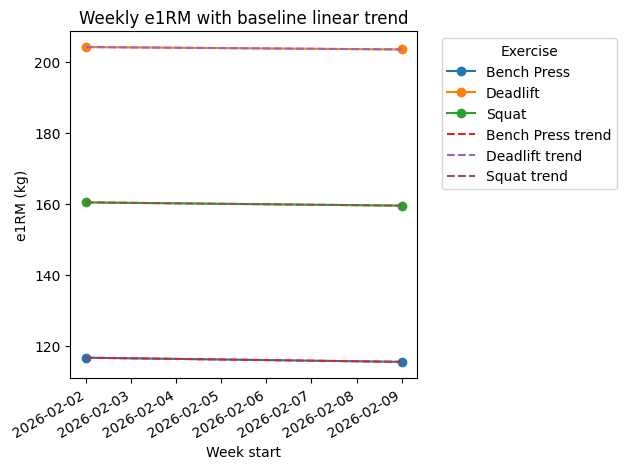

In [21]:
# Visualize baseline trendlines

ax = wide.plot(marker="o")

for exercise, params in trend_results.items():
    x = np.arange(len(wide))
    y = params["intercept"] + params["slope_per_week"] * x
    ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")

ax.set_title("Weekly e1RM with baseline linear trend")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")

# Position the legend outside the plot area
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Add uncertainty bands (e.g., +/- 5 kg) around the trendlines

residuals = [] # to store residuals for each exercise

for exercise, params in trend_results.items(): # loop through each exercise and its trend parameters
    sub = trend_df[trend_df["exercise"] == exercise] # filter the data for the current exercise
    
    y_hat = params["intercept"] + params["slope_per_week"] * sub["week_index"].values # calculate the predicted values from the trendline
    res = sub["e1rm"].values - y_hat # calculate the residuals (actual - predicted)
    
    residuals.append( # store the residuals in a DataFrame for later analysis
        pd.DataFrame({
            "exercise": exercise,
            "week_start": sub["week_start"],
            "residual": res
        })
    )
    
residuals_df = pd.concat(residuals) # combine the residuals from all exercises into a single DataFrame
residuals_df

,exercise,week_start,residual
0,Bench Press,2026-02-02,4.263256e-14
3,Bench Press,2026-02-09,2.842171e-14
1,Deadlift,2026-02-02,1.136868e-13
4,Deadlift,2026-02-09,1.136868e-13
2,Squat,2026-02-02,2.842171e-14
5,Squat,2026-02-09,2.842171e-14


In [23]:
# Estimate uncertainty as the standard deviation of the residuals for each exercise

uncertainty = (
    residuals_df.groupby("exercise")["residual"]
    .std()
    .rename("sigma")
)
uncertainty

exercise
Bench Press    1.004859e-14
Deadlift       0.000000e+00
Squat          0.000000e+00
Name: sigma, dtype: float64

/var/folders/1n/nt517y8n3t91v8pb1n5b6dxw0000gn/T/ipykernel_50888/2344553941.py:11: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")


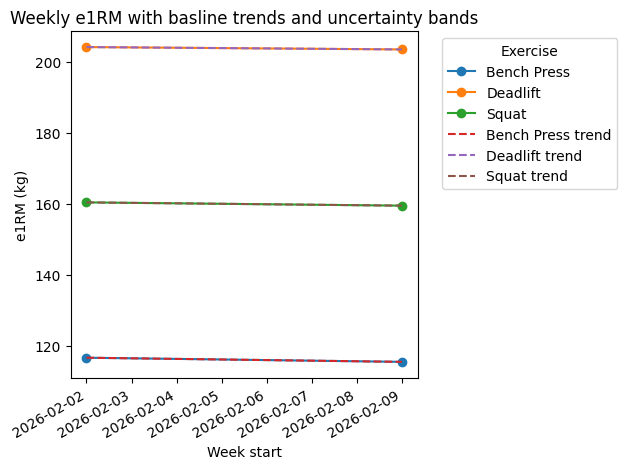

In [24]:
# Plot trend + +/- sigma bands

ax = wide.plot(marker="o")

for exercise, params in trend_results.items():
    sigma = uncertainty.loc[exercise] # get the standard deviation of residuals for the current exercise
    
    x = np.arange(len(wide))
    y = params["intercept"] + params["slope_per_week"] * x
    
    ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")
    ax.fill_between(wide.index, y - sigma, y + sigma, alpha=0.2) # add a shaded area representing the uncertainty around the trendline

ax.set_title("Weekly e1RM with basline trends and uncertainty bands")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")

# Position the legend outside the plot area
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Phase 5 - Diminishing Returns + Scenario Forecasting

### Modeling Philosophy

Rules
1. Strength gains slow over time
    * Diminishing retruns are non-negotiable
2. Adherence affects the rate and not the direction
    * Missing sessions reduces slope and not max potential
3. Forecasts will widen over time
    * Uncertainty grows and never shrinks
4. We will be forecasting weekly e1RM and not the daily noise

Model
A logarithmic adaptation function because it cleanly captures the reality of strength training: big early gains that gradually taper off, without complex math.

With this in mind, we will use a logarithmic decay on weekly gains.

Conceptually:
    Expected e1RMₜ₊₁ = e1RMₜ + Δ₀ · log(1 + kₜ)^-1
    
Where:
* kₜ = training stimulus/dose in week t (e.g., volume × intensity)
* Δ₀ = max weekly gain potential when fresh (e.g., 2.5 kg for a squat)

Why it fits your criteria:
* ✅ Interpretable: Δ₀ = "best possible weekly gain when new to the program"
* ✅ Tunable: Adjust Δ₀ per lifter/exercise; kₜ scales with effort
* ✅ Explainable: "You gain fastest when starting out. Each extra week of hard training still helps—but less than the week before. Like learning a language: easy at first, harder to level up later."

Why not logistic? Logistic curves need extra parameters (e.g., asymptote, inflection point) that aren't reliably estimable from typical 8–12 week training blocks. Log form gives 80% of the insight with 20% of the complexity—ideal for practical forecasting.

## Define Baseline weekly gain (Δ₀)

We do not estimate this from 2 weeks of data, instead we will anchor it to evidence and my training status.

For intermediate lifters:

* Bench: ~0.25-0.5 kg/week e1RM early
* Squat: ~0.5-0.75 kg/week 
* Deadlift: ~0.75-1.0 kg/week

Although optimistic, these value represent realistic early-phase figures. 
We will encode them explicitly so the assumptions are transparent.


## Define adherence scenarios
Adherence modifies effective weekly gain, not the curve shape

| Scenario | Multiplier | Interpretation |
|:---------|:----------:|:---------------|
| 100%     | 1.0        | Never miss key sessions |
| 75%      | 0.7        | Occasional misses |
| 50%      | 0.45       | Inconsistent training |

In [26]:
# Define Forecast Horizon

weeks_ahead = 44 # ~Feb 2026 -> Dec 2026

weeks = np.arange(weeks_ahead) # create an array of week indices for the forecast horizon (0 to 43 weeks ahead)

In [36]:
# Extract last osbserved e1RM as a starting point for the forecast (week_index = 0 for the forecast)

weekly_clean = weekly.copy()
weekly_clean["week_start"] = pd.to_datetime(weekly_clean["week_start"])
weekly_clean["exercise"] = weekly_clean["exercise"].astype(str).str.strip() # ensure exercise names are lowercase for consistency

last_obs = (
    weekly_clean.sort_values("week_start")
    .groupby("exercise", as_index=True) # group by exercise to get the last observation for each lift
    .tail(1) # get the last observation
    .set_index("exercise")["e1rm"] # set the index to exercise name
)

print(last_obs)
print("Index:", last_obs.index.tolist())

exercise
Bench Press    115.5
Deadlift       203.5
Squat          159.5
Name: e1rm, dtype: float64
Index: ['Bench Press', 'Deadlift', 'Squat']


In [35]:
last_obs.index.to_list()

['Bench Press', 'Deadlift', 'Squat']

In [39]:
# Define baseline weekly gains (explicit assumptions)

baseline_gains = {
    "Squat": 0.6, # kg per week
    "Bench Press": 0.4,
    "Deadlift": 0.9
}

print("baseline_gains keys:", list(baseline_gains.keys()))

baseline_gains keys: ['Squat', 'Bench Press', 'Deadlift']


In [40]:
# Define diminishing returns function

def diminishing_gain(delta0, week, k=12): # k is the diminishing returns parameter
    """

    delta0: intial weekly gain (kg)
    week: weeks since start of forecast
    k: controls how quickly gains diminish (higher k = slower diminishing)
    """
    return delta0 / np.log1p(week + k) # use log1p to avoid log(0) and control the shape of diminishing returns

In [41]:
print(type(last_obs))
print(last_obs)
print("last_obs.index:", last_obs.index)

<class 'pandas.Series'>
exercise
Bench Press    115.5
Deadlift       203.5
Squat          159.5
Name: e1rm, dtype: float64
last_obs.index: Index(['Bench Press', 'Deadlift', 'Squat'], dtype='str', name='exercise')


In [42]:
# Generate scenario projections

scenarios = {
    "100%": 1.0, # 100% adherence to weekly program and no misses
    "75%": 0.7, # 75% or occasional adherence (e.g., due to missed sessions, fatigue, etc.)
    "50%": 0.45 # inconsistent adherence (e.g., due to frequent missed sessions, fatigue, etc.)
}

projections = []

for exercise, e0 in last_obs.items(): # Loop through each exercise to generate projections
    e0 = float(e0) # ensure e0 is a float for calculations
    for scenario, mult in scenarios.items(): # Loop through each scenario multiplier
        values = [e0] # start with the last observed e1RM as the first value in the projection
        
        for w in weeks[1:]: # Loop through each week in the forecast horizon (starting from the second week since the first value is the last observed e1RM)
            gain = diminishing_gain(baseline_gains[exercise], w) * mult # calculate the gain for the current week using the diminishing returns function and scenario multiplier
            values.append(values[-1] + gain) # add the gain to the last projected value to get the new projected e1RM and append it to the values list
            
        projections.append(
            pd.DataFrame({
                "week_idx": weeks,
                "exercise": exercise,
                "scenario": scenario,
                "e1rm": values
            })
        ) # Append the projection for the current exercise and scenario to the projections list as a DataFrame

projections_df = pd.concat(projections, ignore_index=True) # Concatenate all the projections into a single DataFrame
projections_df.head()

,week_idx,exercise,scenario,e1rm
0,0,Bench Press,100%,115.500000
1,1,Bench Press,100%,115.651569
2,2,Bench Press,100%,115.799277
3,3,Bench Press,100%,115.943547
4,4,Bench Press,100%,116.084729


In [44]:
projections_df["exercise"].value_counts()


exercise
Bench Press    132
Deadlift       132
Squat          132
Name: count, dtype: int64

In [45]:

projections_df["scenario"].value_counts()

scenario
100%    132
75%     132
50%     132
Name: count, dtype: int64

In [47]:
print(len(projections_df))

396


In [48]:
projections_df.groupby(["exercise", "scenario"]).size()

exercise     scenario
Bench Press  100%        44
             50%         44
             75%         44
Deadlift     100%        44
             50%         44
             75%         44
Squat        100%        44
             50%         44
             75%         44
dtype: int64

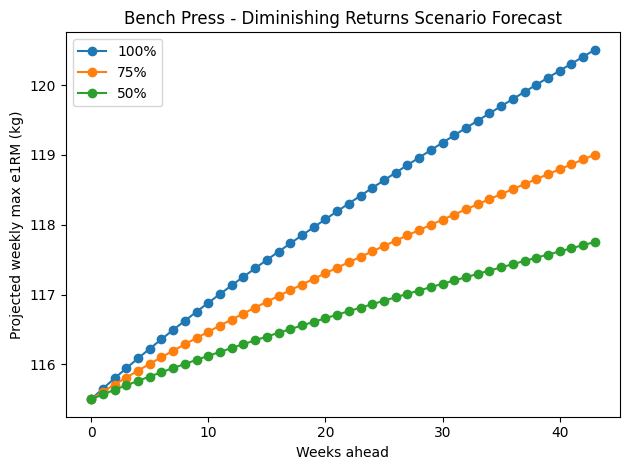

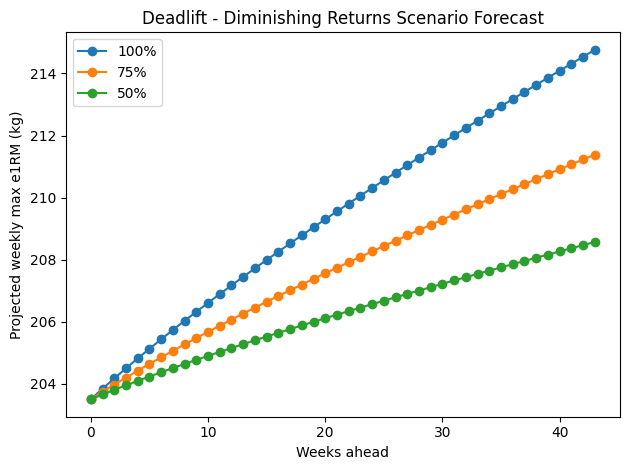

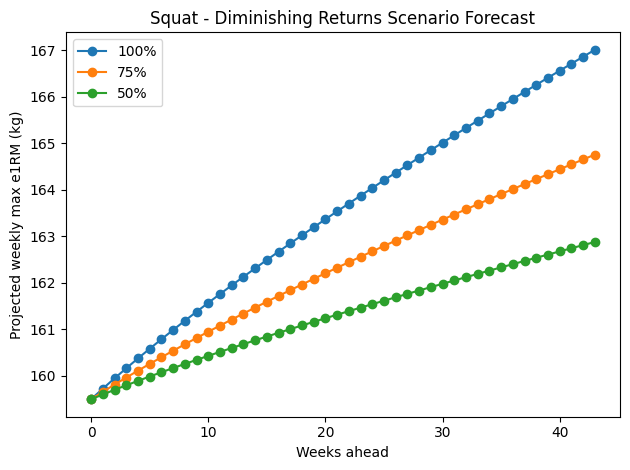

In [49]:
# Plot scenario curves (one lift per chart)

for exercise in projections_df["exercise"].unique():
    sub = projections_df[projections_df["exercise"] == exercise] # filter the projections for the current exercise
    
    plt.figure() # create a new figure for each exercise
    for scenario in sub["scenario"].unique(): # loop through each scenario for the current exercise
        scenario_sub = sub[sub["scenario"] == scenario] # filter the data for the current scenario
        plt.plot(scenario_sub["week_idx"], scenario_sub["e1rm"], marker="o", label=scenario) # plot the projected e1RM over time for the current scenario
    
    plt.title(f"{exercise} - Diminishing Returns Scenario Forecast")        
    plt.xlabel("Weeks ahead")
    plt.ylabel("Projected weekly max e1RM (kg)")    
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Adding Uncertainty bands 

These curves above are deterministic. TO add realsim to the outcomes we need to add uncertainty

To add uncertainty we will approach it in 3 ways;

* Estimate a sigma per lift from historical residuals
* Add noise each week
* Run Monte Carlo to get 80%/95% bands

In [50]:
# Inserting uncertainty bands (using the same sigma from the historical residuals)

import numpy as np

# Estimated sigma (weekly noise) from actual weekly data
weekly_clean = weekly.copy()
weekly_clean["week_start"] = pd.to_datetime(weekly_clean["week_start"])
weekly_clean["exercise"] = weekly_clean["exercise"].astype(str).str.strip() # ensure exercise names are lowercase for consistency

# Estimate volatity (sigma) from the week-to-week differences

diff_sigma = (
    weekly_clean.groupby("exercise")["e1rm"]
    .diff() # calculate week-to-week differences in e1RM for each exercise
    .groupby(weekly_clean["exercise"]) # group by exercise to calculate the standard deviation of differences for each lift
    .std() # calculate the standard deviation of differences for each exercise
    .fillna(1.0) # fill any NaN values with a default sigma of 1.0 kg (in case of insufficient data to calculate sigma for an exercise)
)

diff_sigma

exercise
Bench Press    1.0
Deadlift       1.0
Squat          1.0
Name: e1rm, dtype: float64